# Multi-parameter, multi-object calibration
In this notebook I take a first look at the results of the multi-parameter, multi-object calibration.

**Multi-parameter**, **Mulit-object** you ask?! Let me exlpain... For the glacier model to work correctly (or at least as best as possible) a thorough calibration is necessary. There are three tuning paramaters which I use, the (hypothetical) equilibrium year ($t^*$, `t_star`), the precipitation scaling factor (`prcp_scaling_factor`) and the sliding parameter, also known as Glen's A parametere (`glen_a`). Hence, *multi-parameter*.
The model output is validated against historic glacier length (change) records. The model *skill* is reflected in the correlation coefficient as well as the root mean squared deviation. We seek a result with an optimal combination of both skill scores (i.e., high correlation coeffiecietn and low RMDS), hence *multi-object*.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
# read created Dataset
path = '../data/glen_a.nc'
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:     (glen_a_fac: 5, prcp_fac: 4, t_star: 6)
Coordinates:
  * t_star      (t_star) int64 1935 1940 1945 1950 1955 1960
  * prcp_fac    (prcp_fac) float64 1.0 1.25 1.5 1.75
  * glen_a_fac  (glen_a_fac) float64 0.1 0.5 1.0 2.0 10.0
Data variables:
    corr        (glen_a_fac, prcp_fac, t_star) float64 ...
    rmsd        (glen_a_fac, prcp_fac, t_star) float64 ...
    amp_diff    (glen_a_fac, prcp_fac, t_star) float64 ...

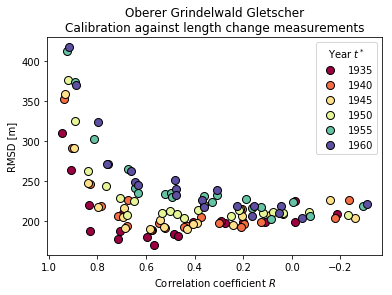

In [191]:
cmap = matplotlib.cm.get_cmap('Spectral', ds.t_star.size)
for i, t_star in enumerate(ds.t_star.values):
    x = ds.corr.sel(t_star=t_star)
    y = ds.rmsd.sel(t_star=t_star)
    plt.plot(x,y, ls='None', marker='o', color=cmap(i),
             markeredgecolor='k', markersize=8)
    
# get figure axes
ax = plt.gca()
ax.invert_xaxis()
# legend
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[::4], ds.t_star.values, title='Year $t^*$')
# labels, title
ax.set_xlabel('Correlation coefficient $R$')
ax.set_ylabel('RMSD [m]')
ax.set_title('Oberer Grindelwald Gletscher\n' + 'Calibration against length change measurements');

## Get 2003 reference length

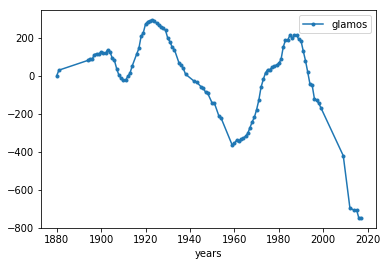

In [8]:
# read reference measurements
fn = '/Users/oberrauch/work/grindelwald/data/length_ref_glamos.csv'
length_glamos = pd.read_csv(fn, index_col=0)
length_glamos.plot(marker='.')

In [11]:
# look at points around 2003
year_of_interest = 2003
window_size = 20
length_glamos.loc[year_of_interest-window_size/2:year_of_interest+window_size/2]

,glamos
years,
1993,19.0
1994,-43.0
1995,-50.0
1996,-120.0
1997,-130.0
1998,-145.0
1999,-170.0
2009,-420.0
2012,-695.0


There is a big data gap between 1999 and 2009 (or even 2012). Around that time the lower part of the glacier (below the icefall) seperated from the accumulation area. Therefore the measured length does not adequately represent the OGGM glacier length, where no seperation happend...

Hence, we need a different approach to identify an estimated glacier length in 2003.

**Best fitting curve based on 1996 - 1999**

In [101]:
length_glamos.loc[1996:1999].diff()

,glamos
years,
1996,NaN
1997,-10.0
1998,-15.0
1999,-25.0


In [125]:
my_lenght_diff = -10+np.cumsum(np.arange(0,-7*5,-5))
my_length = np.cumsum(my_length_diff)-120
my_length = pd.Series(my_length, index=np.arange(1997, 1997+my_diff.size))

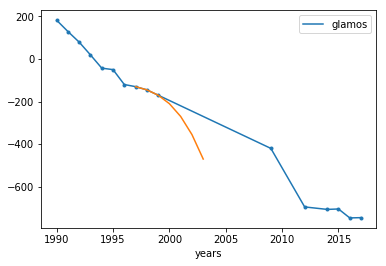

In [126]:
length_glamos.loc[1990:].plot(marker='.')
my_length.plot()

Well... that didn't work as planned.

**Linear interpolation based on `n` years before 1999**

In [219]:
n = 4
t1 = 1999
t0 = t1 - n
slope = ((length_glamos.loc[t0] - length_glamos.loc[t1]) / (t0 - t1)).values[0]
print('Avg. of {} m per year'.format(slope))

Avg. of -30.0 m per year


In [220]:
index = np.arange(t0, 2004)
my_length_diff = np.repeat(slope, index.size-1)
my_length = np.insert(np.cumsum(my_length_diff), 0, 0) + length_glamos.loc[t0].values[0]
my_length = pd.Series(my_length, index=index)
print('Interpolated length in 2003: {:.1f} m'.format(my_length.loc[2003]))

Interpolated length in 2003: -290.0 m


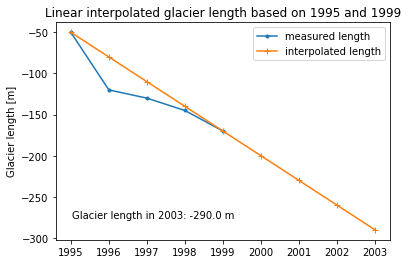

In [221]:
length_glamos.loc[t0:2005].plot(marker='.', legend=False)
my_length.plot(marker='+')

# make plot fancier
ax = plt.gca()
title = 'Linear interpolated glacier length based on {} and {}'.format(t0, t1)
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length [m]')
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels, ['measured length', 'interpolated length'])
text = 'Glacier length in 2003: {:.1f} m'.format(my_length.loc[2003])
ax.text(0.05, 0.1, text, transform=ax.transAxes);

In [222]:
n = 5
t1 = 1999
t0 = t1 - n
slope = ((length_glamos.loc[t0] - length_glamos.loc[t1]) / (t0 - t1)).values[0]
print('Avg. of {} m per year'.format(slope))

Avg. of -25.4 m per year


In [223]:
index = np.arange(t0, 2004)
my_length_diff = np.repeat(slope, index.size-1)
my_length = np.insert(np.cumsum(my_length_diff), 0, 0) + length_glamos.loc[t0].values[0]
my_length = pd.Series(my_length, index=index)
print('Interpolated length in 2003: {:.1f} m'.format(my_length.loc[2003]))

Interpolated length in 2003: -271.6 m


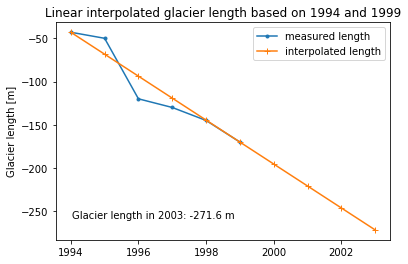

In [224]:
length_glamos.loc[t0:2005].plot(marker='.', legend=False)
my_length.plot(marker='+')

# make plot fancier
ax = plt.gca()
title = 'Linear interpolated glacier length based on {} and {}'.format(t0, t1)
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length [m]')
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels, ['measured length', 'interpolated length'])
text = 'Glacier length in 2003: {:.1f} m'.format(my_length.loc[2003])
ax.text(0.05, 0.1, text, transform=ax.transAxes);

In [225]:
n = 10
t1 = 1999
t0 = t1 - n
slope = ((length_glamos.loc[t0] - length_glamos.loc[t1]) / (t0 - t1)).values[0]
print('Avg. of {} m per year'.format(slope))

Avg. of -36.1 m per year


In [226]:
index = np.arange(t0, 2004)
my_length_diff = np.repeat(slope, index.size-1)
my_length = np.insert(np.cumsum(my_length_diff), 0, 0) + length_glamos.loc[t0].values[0]
my_length = pd.Series(my_length, index=index)
print('Interpolated length in 2003: {:.1f} m'.format(my_length.loc[2003]))

Interpolated length in 2003: -314.4 m


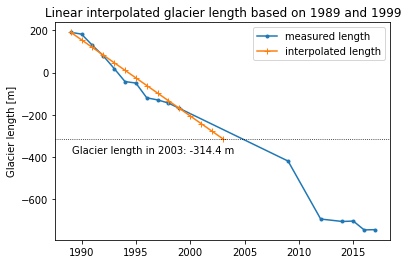

In [245]:
length_glamos.loc[t0:].plot(marker='.', legend=False)
my_length.plot(marker='+')

# make plot fancier
ax = plt.gca()
title = 'Linear interpolated glacier length based on {} and {}'.format(t0, t1)
ax.set_title(title)
ax.set_xlabel('')
ax.set_ylabel('Glacier length [m]')
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels, ['measured length', 'interpolated length'])
text = 'Glacier length in 2003: {:.1f} m'.format(my_length.loc[2003])
ax.text(0.05, 0.4, text, transform=ax.transAxes);
ax.axhline(my_length.loc[2003], ls=':', lw='0.8', c='k')

In [228]:
my_length.loc[2003]

-314.40000000000015